전체 사고 데이터에 사망자수, 중상자수, 경상자수, 부상신고자수 수치만 가지고 PCA 돌려 전체 사고에 대한 클러스터링을 해보았습니다.  

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#한글 깨짐 방지
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from scikitplot.decomposition import plot_pca_component_variance
from sklearn.preprocessing import StandardScaler

# 데이터 가져오기

In [32]:
df = pd.read_csv("Kor_Train.csv", encoding='euc-kr')

In [34]:
col = ['사망자수', '중상자수', '경상자수', '부상신고자수']

In [35]:
X = df[col]

# PCA

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [37]:
pca = PCA()

In [38]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
scaler.mean_

array([1.04089947, 0.29999601, 0.25050925, 0.03011543])

In [40]:
scaler.scale_

array([0.25248843, 1.05213633, 1.14532564, 0.54171709])

In [41]:
pd.DataFrame(pca.components_.T,
             index=X.columns,
             columns=['PC' + str(i+1) for i in range(len(pca.components_))])

,PC1,PC2,PC3,PC4
사망자수,0.388464,-0.634949,0.637818,0.197797
중상자수,0.599387,-0.201879,-0.352065,-0.689949
경상자수,0.592974,0.163933,-0.407284,0.675002
부상신고자수,0.371769,0.727468,0.550780,-0.170936


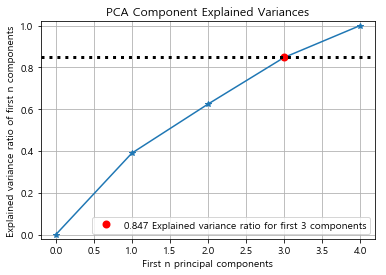

In [42]:
plot_pca_component_variance(pca, target_explained_variance=0.8);

In [43]:
pca.explained_variance_ratio_

array([0.38985231, 0.23430471, 0.22302299, 0.15281999])

# 주성분 수 선택

전체 분산의 80% 이상을 설명하려면 PC 3개 필요하다고 판단. PC 3개로 데이터를 구성하여 GMM 돌림.

In [44]:
X_pca_array = pca.transform(X_scaled)

In [92]:
X_pca = pd.DataFrame(X_pca_array).loc[:,:2] #PC 3개로 X_pca 데이터 구성
X_pca.sample(5)

,0,1,2
19529,-0.384194,0.084117,0.05553
24119,-0.384194,0.084117,0.05553
11748,-0.384194,0.084117,0.05553
20119,-0.384194,0.084117,0.05553
15400,-0.384194,0.084117,0.05553


In [93]:
df_plot = X_pca.copy() #플랏팅을 위해 따로 복사해놓은 데이터 df_plot

# GMM

In [94]:
# now let's try GMM clustering, which tries to fit normally-distributed clusters, 
# and might be the case when measuring things like petal and sepal sizes...

from sklearn.mixture import GaussianMixture
nclusters = 13 # 클러스터 갯수는 AIC, BIC 스코어 보고 수정 해야 함
gmm = GaussianMixture(n_components=nclusters, covariance_type='full')
gmm.fit(X_pca)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_pca)
y_cluster_gmm

array([4, 5, 4, ..., 4, 5, 4], dtype=int64)

In [95]:
# add the GMM clusters to our data table and plot them
df_plot.columns=['PC' + str(i+1) for i in range(len(df_plot.T))]
df_plot['ClusterGMM'] = y_cluster_gmm

In [96]:
df_plot.head()

,PC1,PC2,PC3,ClusterGMM
0,-0.384194,0.084117,0.055530,4
1,1.272912,-0.156501,-0.969313,5
2,-0.384194,0.084117,0.055530,4
3,-0.384194,0.084117,0.055530,4
4,0.185492,-0.107759,-0.279089,0


In [98]:
def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = plt.cm.get_cmap('Set2')

    # we can use pandas to plot each cluster on the same graph.
    # see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA)");

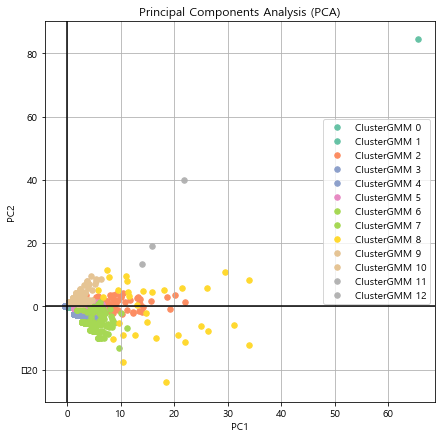

In [99]:
plotData(df_plot, 'ClusterGMM')

# 클러스터 갯수 정하기

BIC, AIC 모두 확인해본 결과, 13개 정도가 적당할 것으로 판단되어 13개로 클러스터를 만들었습니다.

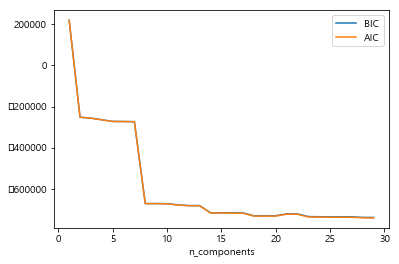

In [101]:
n_components = np.arange(1, 30) 
#30개는 제가 임의로 정한 숫자입니다. 이 경우 전체 데이터가 2만개가 넘어서 이렇게 했고, 보통은 len(X_pca) 해서 넣으면 괜찮을 것 같습니다. 
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca)
          for n in n_components]
plt.plot(n_components, [m.bic(X_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# 클러스터에 속할 확률로 새로운 변수 만들기

In [102]:
a = pd.DataFrame(gmm.predict_proba(X_pca))

In [103]:
a.shape

(25037, 13)

In [104]:
a.columns = ['WholeC' + str(i+1) for i in range(len(a.T))]

In [105]:
a.sample()

,WholeC1,WholeC2,WholeC3,WholeC4,WholeC5,WholeC6,WholeC7,WholeC8,WholeC9,WholeC10,WholeC11,WholeC12,WholeC13
22619,6.119005e-08,0.0,3.098040e-15,0.0,1.0,1.753382e-08,2.385659e-14,1.167305e-17,5.036725e-17,7.262416e-13,0.0,0.0,0.0


In [106]:
pd.DataFrame.to_csv(a, "cluster_whole.csv")